## Human Resources Analytics

In [1]:
import pandas as pd
from minio import Minio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

### Downloading Dataset from Data Lake

In [3]:
client.fget_object(
            "processing",
            "employees_dataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")

In [4]:
df.head()

,department,salary,left,department.1,salary.1,left.1,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


#### Organizing the dataset

In [5]:
df = df[['department', 'salary', 'mean_work_last_3_months',
       'number_projects', 'satisfaction_level', 'last_evaluation',
       'time_in_company', 'work_accident','left']]

In [6]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


#### Checking for missing records

In [7]:
df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [8]:
df.dropna(inplace=True)

#### Changing data types

In [9]:
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14999 non-null  object 
 1   salary                   14999 non-null  object 
 2   mean_work_last_3_months  14999 non-null  int32  
 3   number_projects          14999 non-null  int32  
 4   satisfaction_level       14999 non-null  float64
 5   last_evaluation          14999 non-null  float64
 6   time_in_company          14999 non-null  int32  
 7   work_accident            14999 non-null  int32  
 8   left                     14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 878.8+ KB


In [11]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


#### Renaming attributes

In [12]:
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

#### Label encoder

In [13]:
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

#### Separating the data sets

In [14]:
target_name = 'turnover'
X = df.drop('turnover', axis=1)
y = df[target_name]

### Splitting into train and test data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.2,random_state = 42,stratify = y)

In [17]:
train = pd.concat([Xtrain, ytrain], axis=1)
test = pd.concat([Xtest, ytest], axis=1)

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(Xtrain, ytrain)

In [20]:
importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns

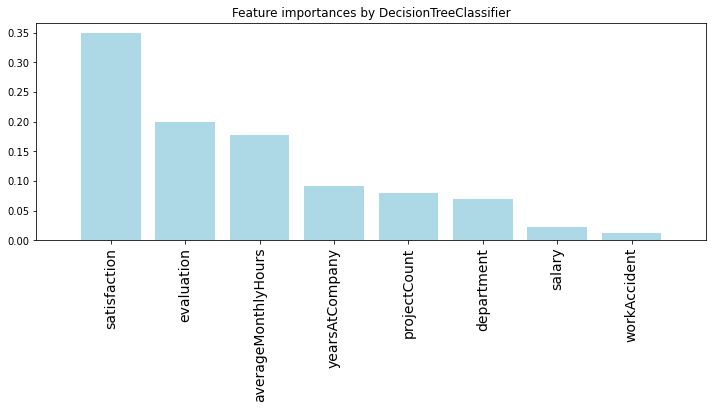

In [21]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Select features

In [22]:
X = df[["satisfaction","evaluation","averageMonthlyHours","yearsAtCompany"]]

In [34]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.2,random_state = 42,stratify = y)

In [35]:
train = pd.concat([Xtrain, ytrain], axis=1)
test = pd.concat([Xtest, ytest], axis=1)

#### Setting a baseline

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [24]:
# Return always zero because we are handling with unbalanced classes
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [25]:
def accuracy_result(y_test,y_predict):
    acc = accuracy_score(y_test, y_predict)
    print (f"Accuracy = {np.round(acc,2)}")

In [26]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print (f"\n{model} AUC = {roc_}\n")
    print(classfication_report)

In [27]:
y_predict = base_rate_model(Xtest)

In [28]:
accuracy_result(ytest, y_predict)

Accuracy = 0.76


In [29]:
roc_classification_report_results("Base Model", ytest, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2286
           1       0.00      0.00      0.00       714

    accuracy                           0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



d:\projetos_python2\bootcampds\.venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Pycaret

In [30]:
from pycaret.classification import *

In [36]:
s = setup(
        train,
        test_data=test,
        target = "turnover",
        numeric_features = ["yearsAtCompany"],
        normalize = True,
        normalize_method = "minmax",
        data_split_stratify = True,
        fix_imbalance = True,
        silent=True)

,Description,Value
0,session_id,3172
1,Target,turnover
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(11999, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


#### Compare different models and select the best

In [37]:
best = compare_models(fold = 5,sort = 'Precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8455,0.8070,0.6598,0.6815,0.6701,0.5693,0.5697,0.2140
gbc,Gradient Boosting Classifier,0.8340,0.8094,0.6878,0.6419,0.6636,0.5536,0.5546,0.3540
rf,Random Forest Classifier,0.8142,0.7830,0.5660,0.6213,0.5919,0.4721,0.4732,0.5080
et,Extra Trees Classifier,0.8102,0.7537,0.5474,0.6138,0.5783,0.4564,0.4579,0.3740
ada,Ada Boost Classifier,0.8122,0.8015,0.6899,0.5911,0.6362,0.5107,0.5138,0.1680
dt,Decision Tree Classifier,0.7349,0.6657,0.5061,0.4497,0.4761,0.2995,0.3006,0.0220
qda,Quadratic Discriminant Analysis,0.7191,0.7603,0.7574,0.4471,0.5622,0.3751,0.4035,0.0240
knn,K Neighbors Classifier,0.7201,0.7534,0.7018,0.4446,0.5443,0.3567,0.3761,0.0520
nb,Naive Bayes,0.7084,0.7130,0.5926,0.4209,0.4920,0.2958,0.3044,0.0140
ridge,Ridge Classifier,0.6819,0.0000,0.6293,0.3948,0.4852,0.2722,0.2877,0.0160


#### Creating the model

In [38]:
best

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3172, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
best_model = create_model(best, fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8425,0.7910,0.6270,0.6845,0.6545,0.5527,0.5536
1,0.8525,0.8252,0.6918,0.6894,0.6906,0.5937,0.5937
2,0.8471,0.7983,0.6381,0.6952,0.6655,0.5666,0.5675
3,0.8379,0.8123,0.6556,0.6614,0.6585,0.5522,0.5522
4,0.8474,0.8082,0.6865,0.6770,0.6817,0.5814,0.5814
Mean,0.8455,0.8070,0.6598,0.6815,0.6701,0.5693,0.5697
SD,0.0049,0.0118,0.0257,0.0117,0.0138,0.0162,0.0160


#### tunning the model

In [45]:
tuned_model = tune_model(
        best_model,
        fold=5,
        n_iter = 50,
        optimize = 'Precision')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8425,0.7960,0.6182,0.6881,0.6513,0.5499,0.5513
1,0.8488,0.8183,0.6778,0.6837,0.6807,0.5816,0.5817
2,0.8467,0.7940,0.6136,0.7048,0.6561,0.5580,0.5602
3,0.8329,0.8040,0.6451,0.6508,0.6479,0.5384,0.5384
4,0.8499,0.8049,0.6690,0.6908,0.6797,0.5818,0.5819
Mean,0.8442,0.8035,0.6447,0.6836,0.6632,0.5620,0.5627
SD,0.0062,0.0086,0.0259,0.0179,0.0142,0.0173,0.0171


#### Finalize the model

In [49]:
final_model = finalize_model(tuned_model)

In [50]:
save_model(final_model,'model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['yearsAtCompany'],
                                       target='turnover', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical...
                                 colsample_bytree=1.0, feature_fraction=0.8,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=21,
                                 min_child_weight=0.001, min_split_gain=0.5,
        

#### Transfer to the Data Lake

In [51]:
client.fput_object(
    "curated",
    "model.pkl",
    "model.pkl"
)

In [52]:
df.to_csv("dataset.csv",index=False)

In [53]:
client.fput_object(
    "curated",
    "dataset.csv",
    "dataset.csv"
)